<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Build-Features" data-toc-modified-id="Build-Features-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build Features</a></span></li><li><span><a href="#Split-Train/Test" data-toc-modified-id="Split-Train/Test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Split Train/Test</a></span></li><li><span><a href="#plot-tree-model" data-toc-modified-id="plot-tree-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>plot tree model</a></span></li><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cross-validation</a></span></li><li><span><a href="#Estimation-de-meilleur-paramétrage-pour-le-modèle-xgboost" data-toc-modified-id="Estimation-de-meilleur-paramétrage-pour-le-modèle-xgboost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Estimation de meilleur paramétrage pour le modèle xgboost</a></span></li><li><span><a href="#Ploting-Results" data-toc-modified-id="Ploting-Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Ploting Results</a></span></li></ul></div>

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Build Features

In [3]:
def get_data(filepath):
    """Read and generate the data and get a DataFrame.
        Args:
            filepath (str): File of the raw .csv data .
        Returns:
            data (pandas.core.frame.DataFrame): Data generating in csv file.
    """
    data = pd.read_csv(filepath)
    return data


def encoder_category(data, columns):
    """Encode the categorical type in a specific column to numbers.
            >> ['Male', 'Female] --> [1, 2]
        Args:
            data (pandas.core.frame.DataFrame): Data from the dataSet.
            columns (str): the column to encode
        Returns:
            data (pandas.core.frame.DataFrame): Data after encoding a specific colum.
    """
    encoder = OrdinalEncoder(dtype=np.int)
    for col in columns:
        data[col] = encoder.fit_transform(data[col].values.reshape(-1, 1)) + 1

    return data


def replace_in_col(data, col_name, col_replace):
    """Replace the data inside a column.
        Args:
            data (pandas.core.frame.DataFrame): Data from the dataSet.
            col_name (str): the name of column.
            col_replace (dict): the dictionary of all the specific names we want to replace.
    """
    if col_name in data.columns:
        data[col_name] = data[col_name].replace(col_replace)


def rename_col(data):
    """Rename the columns to french.
        Args:
            data (pandas.core.frame.DataFrame): Data from the dataSet.
    """
    rename_list = ["Id", "Nom", "Hote_id", "Nom_hote", "Departement", "Quartier", 'Latitude', 'Longitude', "Type_chambre",
                   "Prix", "Minimum_nuit", "Nombre_avis", "Dernier_avis", "Avis_par_mois", "Nombre_list_hote", "Disponabilitie_365"]

    columns = list(data.columns)
    if len(columns) == len(rename_list):
        d = dict(zip(columns, rename_list))
        data.rename(columns=d, inplace=True, errors="raise")


def encodeHot_cat(data, col_encode):
    """Encode the categorical column to seperate columns.
        Args:
            data (pandas.core.frame.DataFrame): Data from the dataSet.
            col_encode (str): the column to encode
        Returns:
            data (pandas.core.frame.DataFrame): Data after deleting the encoded column and adding new columns.
    """
    onehot = OneHotEncoder(dtype=np.int, sparse=True)
    nominals = pd.DataFrame(
        onehot.fit_transform(data[col_encode].values.reshape(-1, 1)).toarray(),
        columns=['Depart_' + county for county in data[col_encode].unique()])
    data = pd.concat([data, nominals.reindex(data.index)], axis=1)
    data.drop(columns=[col_encode], axis=1, inplace=True)
    del(nominals)

    return data


def scaling(data, col_scale):
    """Scaling a column in a standard way.
        Args:
            data (pandas.core.frame.DataFrame): Data from the dataSet.
            col_scale (str): the column to scale
        Returns:
            data (pandas.core.frame.DataFrame): Data after deleting the column and adding the scaled one.
        Note:
            for more detail on scaling: http://benalexkeen.com/feature-scaling-with-scikit-learn/
    """
    # Add the standardScaler
    standard_vec = StandardScaler(with_mean=False)

    # Round the data to 2 after point
    nominals = pd.DataFrame(
        np.round(standard_vec.fit_transform(
            data[col_scale].values.reshape(-1, 1)), 2),
        columns=[col_scale + "_scale"])
    data = pd.concat([data, nominals.reindex(data.index)], axis=1)
    data.drop(columns=[col_scale], axis=1, inplace=True)

    # Deleting the unused data
    del(nominals)

    return data


def cleaning(data):
    """Cleaning data to remove or replace the NaN values.
        Args:
            data (pandas.core.frame.DataFrame): Data from the dataSet.
    """
    print("=========== Start Cleaning ===========")
    missing_data = pd.DataFrame(
        round(data.isnull().sum()/data.shape[0]*100, 2), columns=["Pourcentage (%)"])
    print(missing_data.sort_values(by="Pourcentage (%)", ascending=False))
    print("\n")
    print("The pourcentage of missing data in our data is ", missing_data.max())
    print("====1/ Deleting duplicated values====")
    duplicated_vals = data.duplicated().sum()
    print("\t There are ", duplicated_vals)
    print("\t Deleting duplicated data")
    data.drop_duplicates(inplace=True)
    print("\t Deleting Done !!")
    print("====2/ Deleting unnecessary columns====")
    print("\t Deleting the following columns: Nom, Hote_id, Nom_hote,Dernier_avis")
    data.drop(columns=["Nom", "Hote_id", "Nom_hote",
                       "Dernier_avis"], axis=1, inplace=True)
    print("====3/ Replacing NaN with 0====")
    print("\t Replacing NaN in columns Nombre_avis and Avis_par_mois to 0")
    data["Nombre_avis"].fillna(0, inplace=True)
    data["Avis_par_mois"].fillna(0, inplace=True)
    print("===4/ Drop the rest of Nan====")
    data.dropna(how="any", inplace=True)
    print("\t Done!!")
    print("=========== End of Cleaning ===========")
    print("\n")

def get_processed_data(file):
    """Processing the csv file to get cleaned and has all the numerical 
        columns and save it to another file.
        Args:
            file (str): Data from the dataSet.
        Returns:
            data (pandas.core.frame.DataFrame): Data after deleting the column and adding the scaled one.
    """
    print("I- Getting the data from",file.split("/")[-1])
    print("\n")
    df = get_data(file)
    
    print("II- Rename the data")
    print("\n")
    rename_col(df)
    
    print("III- Cleaning the data")
    print("\n")
    cleaning(df)
    
    print("IV- Encoding the data")
    print("\n")
    df = encoder_category(df, ["Quartier", "Type_chambre", "Departement"])
    # df = encodeHot_cat(df, "Departement")
    
    print("IV- Scaling the data")
    print("\n")
    df = scaling(df, "Disponabilitie_365")
    df = scaling(df, "Nombre_avis")
    df = df.set_index('Id')

    print("IV- Saving the data to './data/processed/preprocessing_data_ordinalEnc.csv'")
    print("\n")
    #df.to_csv('./data/processed/preprocessing_data_ordinalEnc.csv', index=False)
    
    return df


df = get_processed_data('https://raw.githubusercontent.com/anass236/ds-project/master/data/raw/AB_NYC_2019.csv')


I- Getting the data from AB_NYC_2019.csv


II- Rename the data


III- Cleaning the data


=========== Start Cleaning ===========
                    Pourcentage (%)
Dernier_avis                  20.56
Avis_par_mois                 20.56
Nom_hote                       0.04
Nom                            0.03
Id                             0.00
Hote_id                        0.00
Departement                    0.00
Quartier                       0.00
Latitude                       0.00
Longitude                      0.00
Type_chambre                   0.00
Prix                           0.00
Minimum_nuit                   0.00
Nombre_avis                    0.00
Nombre_list_hote               0.00
Disponabilitie_365             0.00


The pourcentage of missing data in our data is  Pourcentage (%)    20.56
dtype: float64
====1/ Deleting duplicated values====
	 There are  0
	 Deleting duplicated data
	 Deleting Done !!
====2/ Deleting unnecessary columns====
	 Deleting the following colum

In [5]:
df.head()

,Departement,Quartier,Latitude,Longitude,Type_chambre,Prix,Minimum_nuit,Avis_par_mois,Nombre_list_hote,Disponabilitie_365_scale,Nombre_avis_scale
Id,,,,,,,,,,,
2539,2,109,40.64749,-73.97237,2,149,1,0.21,6,2.77,0.20
2595,3,128,40.75362,-73.98377,1,225,1,0.38,2,2.70,1.01
3647,3,95,40.80902,-73.94190,2,150,3,0.00,1,2.77,0.00
3831,2,42,40.68514,-73.95976,1,89,1,4.64,1,1.47,6.06
5022,3,62,40.79851,-73.94399,1,80,10,0.10,1,0.00,0.20


In [29]:
df['Prix_log'] = np.log(df.Prix + 1)

# Split Train/Test

In [30]:
from sklearn.model_selection import train_test_split

response = 'Prix_log'
features = [col for col in df if col != response and col != 'Prix']
X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[response],
    test_size=0.3
)

# plot tree model

L'affichage de l'arbre d'entrainement pour savoir quelle colonne l'impacte l'entrainement

In [31]:
from xgboost import XGBRegressor
from xgboost import plot_tree
import os
%matplotlib inline

'''
    To show the following graph, make sure te install "Graphiviz", 
    you can download it here : https://graphviz.gitlab.io/download/
    And put your own installation path 
'''
installation_path = 'C:/Program Files (x86)/Graphviz2.38/bin/'
os.environ["PATH"] += os.pathsep + installation_path

xgModel = XGBRegressor()
xgModel.fit(X_train,y_train)

plot_tree(xgModel)

fig = plt.gcf()
fig.set_size_inches(350, 300)

[13:19:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


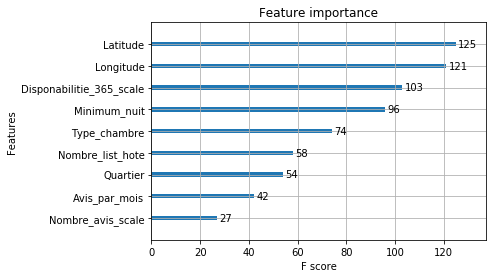

In [32]:
from xgboost import plot_importance
plot_importance(xgModel)

# Cross-validation

In [33]:

import xgboost as xgb

# DMatrix est un type de structure de donnée interne au Xgboost pour une optimisation du mémoire 
dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params={"objective":"reg:squarederror","max_depth":4}

# L1 regularization term on weights. Increasing this value will make model more conservative
l1_params = [1,10,100]

rmses_l1=[]

for reg in l1_params:
    params["alpha"] = reg
    cv_results = xgb.cv(dtrain=dmatrix, params=params,nfold=4,
                        num_boost_round=10,metrics="rmse",as_pandas=True,seed=123)
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])
    
print("Meilleur résultat selon la fonction de L1:")
print(pd.DataFrame(list(zip(l1_params,rmses_l1)), columns=["l1","rmse"]))

Meilleur résultat selon la fonction de L1:
    l1      rmse
0    1  0.476912
1   10  0.482864
2  100  0.501270


# Estimation de meilleur paramétrage pour le modèle xgboost

In [34]:
from sklearn.model_selection import GridSearchCV 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

objective = "reg:squarederror"

# Nombre aléatoire: seed (c'est pour l'ordinateur puisque il n'y a pas de l'aléatoire dans les machines)
seed = 100

# Nombre d'arbres gradient boosted
n_estimators = 100

# Rétrécissement de la taille de l'étape utilisé dans la mise à jour pour éviter le sur-ajustement. 
# Après chaque étape de boost, nous pouvons obtenir directement le poids des nouvelles fonctionnalités
learning_rate = 0.1

# Réduction de perte minimale requise pour effectuer une partition supplémentaire sur le feuille de l'arbre. 
# Plus le gamma est grand, plus l'algorithme sera conservateur.
gamma = 0.1

# Ratio de sous-échantillon des instances de formation. Le sous-échantillonnage aura lieu une fois à chaque itération de boosting
subsample = 0.8

# le ratio de sous-échantillon des colonnes lors de la construction de chaque arbre
colsample_bytree = 0.8

# l1
reg_alpha = 1

# l2
reg_lambda = 1

# Pour affichage des messages
silent = False

parameters = {}
parameters['objective'] = objective
parameters['seed'] = seed
parameters['n_estimators'] = n_estimators
parameters['learning_rate'] = learning_rate
parameters['gamma'] = gamma
parameters['colsample_bytree'] = colsample_bytree
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
parameters['silent'] = silent

scores = []

cv_params = {'max_depth': [2,4,6,8],
             'min_child_weight': [1,3,5,7]
            }

gbm = GridSearchCV(XGBRegressor(
                                objective = objective,
                                seed = seed,
                                n_estimators = n_estimators,
                                learning_rate = learning_rate,
                                gamma = gamma,
                                subsample = subsample,
                                colsample_bytree = colsample_bytree,
                                reg_alpha = reg_alpha,
                                reg_lambda = reg_lambda,
                                silent = silent
 ),
                    
            param_grid = cv_params,
            scoring = "neg_mean_squared_error",
            cv = 5,
            verbose = True
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Meuilleur paramètre:  ",gbm.best_params_)
print("Meilleur score: ",gbm.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  5.7min finished


{'mean_fit_time': array([2.36110482, 2.29660416, 2.43477306, 2.31367769, 3.27178054,
       3.24875498, 3.33993402, 3.63177013, 5.22871795, 5.02774692,
       5.48098726, 4.72140884, 5.79644151, 5.86040874, 6.6233017 ,
       6.00487499]), 'std_fit_time': array([0.40800664, 0.23892595, 0.18910874, 0.11603715, 0.41349878,
       0.14280933, 0.21287288, 0.2240621 , 0.31036972, 0.2921768 ,
       0.71799191, 0.34844138, 0.29995136, 0.28597162, 1.05913274,
       0.49935768]), 'mean_score_time': array([0.02414122, 0.02392454, 0.02075014, 0.02373171, 0.03532152,
       0.0370903 , 0.03787808, 0.03630371, 0.08166566, 0.06472096,
       0.08858895, 0.05654244, 0.0799387 , 0.08569317, 0.1172719 ,
       0.08058424]), 'std_score_time': array([0.00364295, 0.00535992, 0.00318698, 0.00671904, 0.00240449,
       0.00365153, 0.0045482 , 0.00483097, 0.02670565, 0.00625949,
       0.03664209, 0.00231592, 0.00278629, 0.0082969 , 0.0720999 ,
       0.00444575]), 'param_max_depth': masked_array(data=[2, 

In [35]:
predicts = gbm.predict(X_test)

In [36]:
print("RMSE Test: ", np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predicts))))
print("R² score: ", r2_score(np.exp(y_test), np.exp(predicts)))

RMSE Test:  267.9216916850934
R² score:  0.12495736937742741


In [37]:
trainDMat = xgb.DMatrix(data = X_train, label = y_train)
testDMat = xgb.DMatrix(data = X_test, label = y_test)
learning_rate = 0.05
parameters['eta'] = learning_rate

num_boost_round = 3000
early_stopping_rounds = 20

xgbCV = xgb.cv(
    params = parameters, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 5,
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,
    seed = seed     
)

[0]	train-rmse:3.86586+0.00120348	test-rmse:3.86594+0.00500686
[1]	train-rmse:3.48598+0.00110947	test-rmse:3.48605+0.00482177
[2]	train-rmse:3.14474+0.00107526	test-rmse:3.14497+0.00467573
[3]	train-rmse:2.8386+0.00123668	test-rmse:2.83884+0.0047628
[4]	train-rmse:2.56346+0.00118134	test-rmse:2.56384+0.00452146
[5]	train-rmse:2.31718+0.00106686	test-rmse:2.31764+0.00425878
[6]	train-rmse:2.09615+0.0013441	test-rmse:2.09675+0.00432053
[7]	train-rmse:1.89805+0.00129579	test-rmse:1.89887+0.00403063
[8]	train-rmse:1.72082+0.00154273	test-rmse:1.72169+0.00383398
[9]	train-rmse:1.56202+0.00129964	test-rmse:1.56314+0.00395371
[10]	train-rmse:1.42033+0.00112173	test-rmse:1.42174+0.00393381
[11]	train-rmse:1.2944+0.00133934	test-rmse:1.29616+0.00383802
[12]	train-rmse:1.18245+0.00180393	test-rmse:1.18458+0.00388776
[13]	train-rmse:1.08327+0.00223831	test-rmse:1.08581+0.00396655
[14]	train-rmse:0.995044+0.00205794	test-rmse:0.997966+0.00408677
[15]	train-rmse:0.91698+0.00158635	test-rmse:0.92057

[126]	train-rmse:0.395759+0.00204938	test-rmse:0.437338+0.00496132
[127]	train-rmse:0.39552+0.00209627	test-rmse:0.437299+0.00496412
[128]	train-rmse:0.395344+0.00211708	test-rmse:0.437261+0.00497857
[129]	train-rmse:0.395127+0.00219776	test-rmse:0.437265+0.0049626
[130]	train-rmse:0.394898+0.00220234	test-rmse:0.437236+0.00499872
[131]	train-rmse:0.394521+0.00213704	test-rmse:0.437221+0.00506191
[132]	train-rmse:0.394204+0.0020868	test-rmse:0.437145+0.00503614
[133]	train-rmse:0.393946+0.00199586	test-rmse:0.437137+0.00508026
[134]	train-rmse:0.393575+0.00198191	test-rmse:0.437098+0.00505919
[135]	train-rmse:0.393376+0.00201295	test-rmse:0.437105+0.00507019
[136]	train-rmse:0.393136+0.00198619	test-rmse:0.437108+0.00506821
[137]	train-rmse:0.392838+0.00192881	test-rmse:0.437055+0.00510126
[138]	train-rmse:0.392597+0.00191078	test-rmse:0.437017+0.00511976
[139]	train-rmse:0.39235+0.00195253	test-rmse:0.437007+0.00512281
[140]	train-rmse:0.392092+0.00184891	test-rmse:0.437019+0.00515266

[249]	train-rmse:0.37018+0.00236972	test-rmse:0.435637+0.00572554
[250]	train-rmse:0.37002+0.00242513	test-rmse:0.435619+0.00571474
[251]	train-rmse:0.369828+0.00238868	test-rmse:0.435612+0.00575615
[252]	train-rmse:0.369697+0.0024115	test-rmse:0.435619+0.00576081
[253]	train-rmse:0.369531+0.00245736	test-rmse:0.435617+0.00576212
[254]	train-rmse:0.369331+0.00245843	test-rmse:0.435604+0.00576807
[255]	train-rmse:0.369152+0.00246434	test-rmse:0.435625+0.00579269
[256]	train-rmse:0.368951+0.00247159	test-rmse:0.435637+0.00580451
[257]	train-rmse:0.368835+0.00245051	test-rmse:0.435634+0.00581661
[258]	train-rmse:0.368697+0.00246435	test-rmse:0.435636+0.00579853
[259]	train-rmse:0.368475+0.00248796	test-rmse:0.435607+0.00580301
[260]	train-rmse:0.368308+0.00252033	test-rmse:0.435612+0.00582728
[261]	train-rmse:0.368144+0.00251594	test-rmse:0.435619+0.00582392
[262]	train-rmse:0.368025+0.00253344	test-rmse:0.435619+0.00582107


In [20]:
num_boost_round = len(xgbCV)
parameters['eval_metric'] = 'rmse'
progress = dict()
xgbFinal = xgb.train(
    params = parameters, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    evals = [(trainDMat, 'train'), 
             (testDMat, 'test')],
    evals_result=progress
)

[0]	train-rmse:268.261	test-rmse:284.31
[1]	train-rmse:258.547	test-rmse:275.3
[2]	train-rmse:249.689	test-rmse:267.514
[3]	train-rmse:240.851	test-rmse:261.304
[4]	train-rmse:233.095	test-rmse:255.891
[5]	train-rmse:226.786	test-rmse:251.463
[6]	train-rmse:222.586	test-rmse:248.125
[7]	train-rmse:216.786	test-rmse:244.794
[8]	train-rmse:212.468	test-rmse:242.3
[9]	train-rmse:207.857	test-rmse:240.08
[10]	train-rmse:204.803	test-rmse:238.628
[11]	train-rmse:202.063	test-rmse:237.212
[12]	train-rmse:199.659	test-rmse:236.093
[13]	train-rmse:197.214	test-rmse:235.094
[14]	train-rmse:194.957	test-rmse:233.946
[15]	train-rmse:192.823	test-rmse:233.337
[16]	train-rmse:191.121	test-rmse:232.827
[17]	train-rmse:188.882	test-rmse:231.985
[18]	train-rmse:187.605	test-rmse:231.658
[19]	train-rmse:185.874	test-rmse:230.98
[20]	train-rmse:184.589	test-rmse:230.761
[21]	train-rmse:183.505	test-rmse:230.682
[22]	train-rmse:181.908	test-rmse:230.541
[23]	train-rmse:180.974	test-rmse:230.391
[24]	trai

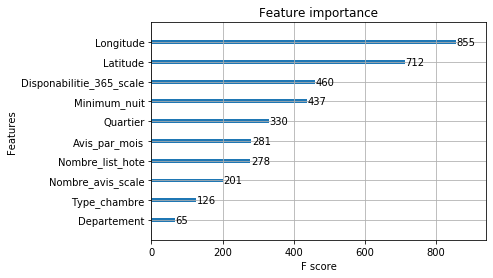

In [38]:
xgb.plot_importance(xgbFinal)

In [42]:
xgbFinal_test_preds = xgbFinal.predict(xgb.DMatrix(np.exp(X_test)))

In [44]:
print("RMSE Test: ", np.sqrt(mean_squared_error(np.exp(y_test), xgbFinal_test_preds)))
print("R² score ", r2_score(np.exp(y_test), xgbFinal_test_preds))

RMSE Test:  299.8428580994391
R² score  -0.09597557627396092


# Ploting Results

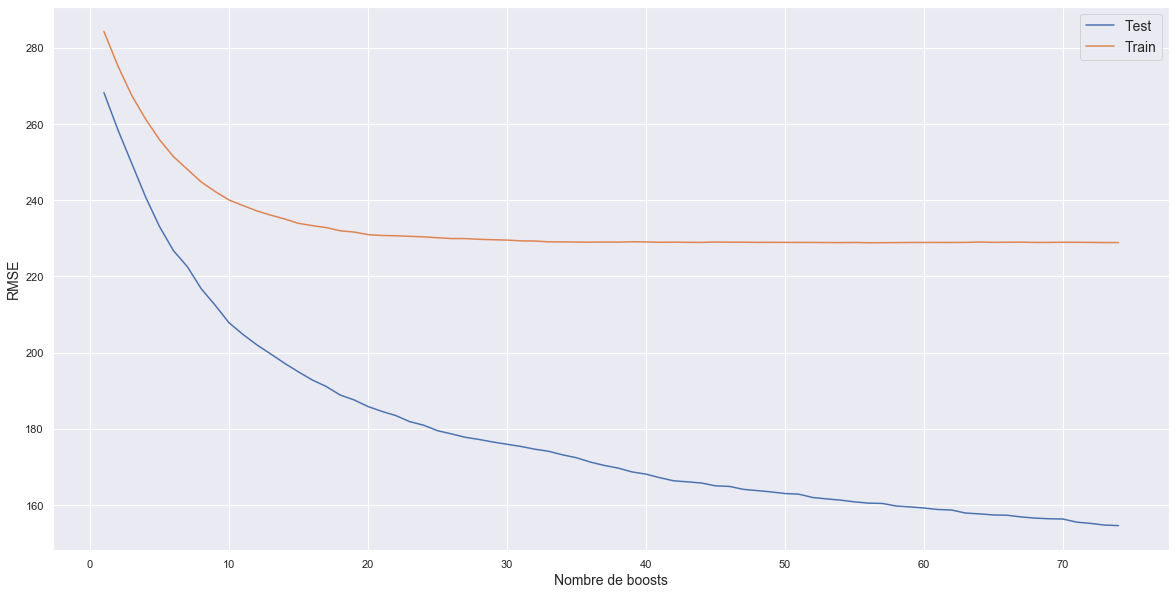

In [49]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,10)})
mlviz_3 = sns.lineplot(range(1,len(progress['train']['rmse'])+1),progress['train']['rmse'])
sns.lineplot(range(1,len(progress['test']['rmse'])+1),progress['test']['rmse'], ax = mlviz_3)
mlviz_3.set_xlabel("Nombre de boosts", fontsize = 14)
mlviz_3.set_ylabel("RMSE", fontsize = 14)
plt.legend(labels=['Test', 'Train'],fontsize=14)